# First Practical work

* Name Student 1:
* NIA Student 1:
* Name Student 2:
* NIA Student 2:
  
This is second practical work skeleton.

It is divided in 3 parts_

1.   Python module load section: load all the needed modules
2.   Google Drive access and mounting
3.   Host load data






## Module load section
We will install the pycuda module in the colaboratory environment, to combine python and CUDA in our code. Because pycuda is not available by default, this task can take a few minutes.

As well we load numpy and matplotlib modules.

In [1]:
!pip install nibabel

We import the Python modules which we will use in the notebook (numpy, pycuda and time module)

In [2]:
import  numpy  as  np
from sys import getsizeof
import time
from os.path import join

In [3]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cProfile

In [4]:
import nibabel as nib

In [5]:
# import your_library here

# Three-dimensional filtering

The objective of the practice is to implement a three-dimensional filtering of information (usually a 3-dimensional image coming from, for example, medical images) to which a preprocessing must be performed for further analysis.

Due to technical limitations, we will assume that the filtering function is a cube of 3x3 voxels (or three-dimensional pixel) and the image will have a maximum size of 1Gbyte (1024x1024x1024), although it will not necessarily be cubic.

## How to filter a voxel?
To filter a voxel we select the coordinates of the voxel we want to filter and the surrounding neighbors in the 3 dimensions (for a 3x3 filter the coefficient corresponding to the voxel to be filtered corresponds to the positions (1,1,1) of the filter mask).
The n selected neighbors are multiplied by the corresponding coefficients in the filter mask, around the selected voxel, and the products are summed, as in the case of 2-dimensional filters.

The result of this sum is the value assigned to the selected position of the resulting voxel.

## Cases at the edges
To calculate the filtered voxel at a position corresponding to one of the edges of the image, we replicate that layer, so that the data of the missing layer is equal to that of the layer to be filtered.
In the case of edges or corners, the value of the corresponding corner is replicated.

## Clapping
The resulting data will be an floating point 32bits data.

## Mount Google Drive and access grant
This part could be used to access to your Google Drive Data, **ONLY IF YOU ARE USING GOOGLE COLABORATORY**. Otherwise leave commented out.

For security and privacy reasons, this permission is temporally, and will be requested every time you restart the notebook.

Your Google Drive will be mounted in the "/content/drive" folder. The first Folder will be "My Drive".

You have to copy your images to a folder in the "My Drive" folder in your Google Drive.

To check your available files, use the cell indicated as "**List Files in Folder**"

In [6]:
#
# from google.colab import drive
# drive.mount("/content/drive")

In [7]:
# !ls /content/drive/My\ Drive/images

## IMAGES DEFINITION

The follow MYDRIVE variable will be used to address where are stored the images files.

Please, change it to your correct location.

All the images should be refered to this directory.

In [8]:
MYDRIVE="./"

We define a variable IMAGE which is constructed joining the "MYDRIVE" varible plus the final path to your image.

In [9]:
#IMAGE=join(MYDRIVE,HERE YOU HAVE TO WRITE THE IMAGE TO LOAD)

In [10]:
IMAGE=join(MYDRIVE,'someones_epi.nii.gz')

In [11]:
print("Image to load: {0}".format(IMAGE))

Image to load: ./someones_epi.nii.gz


Loads an image in a numpy variable, and show.

In [12]:
epi_img = nib.load(IMAGE)
epi_img_data = epi_img.get_fdata().astype(np.float32)
epi_img_data.shape

(53, 61, 33)

In [13]:
epi_img_data_final = epi_img_data.T

In [14]:
epi_img_data_final.shape

(33, 61, 53)

In [15]:
epi_img_data.dtype

dtype('float32')

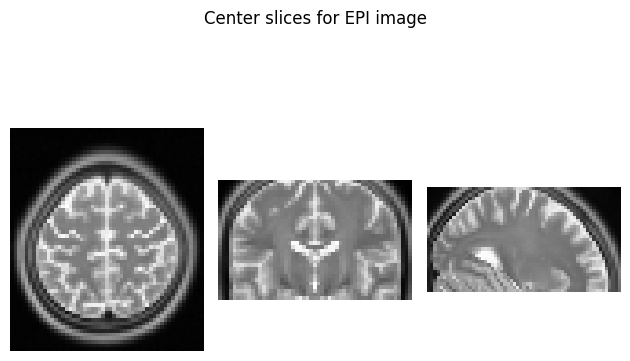

In [16]:
import matplotlib.pyplot as plt

def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    if len(slices) == 1:
        axes = [axes]  # Make axes iterable
    for i, slice in enumerate(slices):
        axes[i].imshow(slice, cmap="gray", origin="lower")
        axes[i].axis('off')  # Hide axis for better display
    plt.tight_layout()
    return fig, axes

slice_0 = epi_img_data_final[26, :, :]
slice_1 = epi_img_data_final[:, 30, :]
slice_2 = epi_img_data_final[:, :, 16]

fig, axes = show_slices([slice_0, slice_1, slice_2])
fig.suptitle("Center slices for EPI image")
plt.show()

## FILTERS DEFINITION

Here we defines our sample filter masks.

In [17]:
#This is an identity filter: the resulting
filter1=np.zeros((3,3,3),dtype=np.float32)
filter1[1,1,1] =1.0

In [18]:
#This is an edge detector filter in xy axis filter: the resulting
filter2=np.zeros((3,3,3),dtype=np.float32)
filter2[0,0,1] = -0.25
filter2[2,0,1] = -0.25
filter2[0,2,1] = 0.25
filter2[2,2,1] = 0.25

In [19]:
#This is an edge detector filter in xz axis: the resulting
filter3=np.zeros((3,3,3),dtype=np.float32)
filter3[0,1,0] = -0.25
filter3[2,1,0] = -0.25
filter3[0,1,2] = 0.25
filter3[2,1,2] = 0.25

# YOUR CODE

In [20]:
import multiprocessing as mp
from multiprocessing import Pool
from multiprocessing import shared_memory
from functools import partial

# Set start method to 'fork' for macOS compatibility
try:
    mp.set_start_method('fork', force=True)
except RuntimeError:
    pass  # Already set


## SETUP EXPERIMENT

Recover the image shape, and select the two first items (rows and columns).

In [21]:
image_shape=epi_img_data_final.shape

In [22]:
def get_voxel_with_boundary(image, x, y, z, shape):
    """
    Get voxel value with proper boundary condition handling.
    Replicates edge/corner values as per assignment requirements.

    Parameters:
    - image: 3D numpy array
    - x, y, z: coordinates (can be out of bounds)
    - shape: tuple with image dimensions (depth, height, width)

    Returns:
    - voxel value with boundary replication
    """
    depth, height, width = shape

    # Clamp coordinates to valid range (replicates boundary values)
    x_clamped = max(0, min(width - 1, x))
    y_clamped = max(0, min(height - 1, y))
    z_clamped = max(0, min(depth - 1, z))

    return image[z_clamped, y_clamped, x_clamped]


def apply_3d_filter_at_position(image, filter_mask, x, y, z, shape):
    """
    Apply 3x3x3 filter at a specific position with correct index mapping.

    This implementation follows the fix from MC_Session_5.pdf:
    - Maps offsets (-1, 0, 1) directly to filter indices (0, 1, 2)
    - Uses c_f = h + 1 and r_f = v + 1 instead of incrementing

    Parameters:
    - image: 3D numpy array
    - filter_mask: 3x3x3 filter
    - x, y, z: position to filter
    - shape: image dimensions

    Returns:
    - filtered value
    """
    total = 0.0

    # Loop over 3x3x3 neighborhood
    for dz in [-1, 0, 1]:  # depth offset
        z_neighbor = z + dz
        z_f = dz + 1  # filter index: maps -1→0, 0→1, 1→2

        for dy in [-1, 0, 1]:  # height offset
            y_neighbor = y + dy
            y_f = dy + 1  # filter index

            for dx in [-1, 0, 1]:  # width offset
                x_neighbor = x + dx
                x_f = dx + 1  # filter index

                # Get voxel value with boundary handling
                voxel_value = get_voxel_with_boundary(image, x_neighbor, y_neighbor, z_neighbor, shape)

                # Apply filter coefficient
                total += voxel_value * filter_mask[z_f, y_f, x_f]

    return total

In [23]:
def process_z_layer(z, shm_name, image_shape, filter_mask, input_image):
    """
    Process a single Z layer (parallelized along Z axis as suggested).
    This function will be called by each parallel process.

    Parameters:
    - z: Z coordinate of the layer to process
    - shm_name: Name of the shared memory block
    - image_shape: Shape of the image
    - filter_mask: 3x3x3 filter to apply
    - input_image: The input image array
    """
    # Access shared memory
    existing_shm = shared_memory.SharedMemory(name=shm_name)
    output_array = np.ndarray(image_shape, dtype=np.float32, buffer=existing_shm.buf)

    depth, height, width = image_shape

    # Process all voxels in this Z layer sequentially
    for y in range(height):
        for x in range(width):
            # Apply filter at this position
            filtered_value = apply_3d_filter_at_position(
                input_image, filter_mask, x, y, z, image_shape
            )
            # Store result in shared memory
            output_array[z, y, x] = filtered_value

    # Close shared memory access (don't unlink, that's done by main process)
    existing_shm.close()


def parallel_3d_filter(input_image, filter_mask, num_processes=None):
    """
    Apply 3D filter in parallel using multiprocessing.
    Parallelizes along Z axis as suggested in the assignment.

    Parameters:
    - input_image: 3D numpy array to filter
    - filter_mask: 3x3x3 filter
    - num_processes: Number of parallel processes (default: CPU count)

    Returns:
    - filtered_image: 3D numpy array with filtered result
    """
    if num_processes is None:
        num_processes = mp.cpu_count()

    image_shape = input_image.shape
    depth, height, width = image_shape

    # Create shared memory for output
    shm = shared_memory.SharedMemory(create=True, size=input_image.nbytes)
    filtered_image_shm = np.ndarray(image_shape, dtype=np.float32, buffer=shm.buf)

    # Initialize with zeros
    filtered_image_shm[:] = 0

    print(f"Starting parallel filtering with {num_processes} processes...")
    print(f"Processing {depth} Z layers in parallel...")

    # Create pool of workers
    with Pool(processes=num_processes) as pool:
        # Create partial function with fixed parameters
        process_func = partial(
            process_z_layer,
            shm_name=shm.name,
            image_shape=image_shape,
            filter_mask=filter_mask,
            input_image=input_image
        )

        # Map each Z layer to a process
        pool.map(process_func, range(depth))

    # Copy result from shared memory
    result = filtered_image_shm.copy()

    # Cleanup
    shm.close()
    shm.unlink()

    return result

In [24]:
def sequential_3d_filter(input_image, filter_mask):
    """
    Sequential (non-parallel) implementation for comparison.
    """
    image_shape = input_image.shape
    depth, height, width = image_shape

    filtered_image = np.zeros(image_shape, dtype=np.float32)

    for z in range(depth):
        for y in range(height):
            for x in range(width):
                filtered_value = apply_3d_filter_at_position(
                    input_image, filter_mask, x, y, z, image_shape
                )
                filtered_image[z, y, x] = filtered_value

    return filtered_image

In [25]:
if __name__ == '__main__':
    # Test with identity filter first
    print("Testing with identity filter (filter1)...")
    start_time = time.time()
    filtered_image = parallel_3d_filter(epi_img_data_final, filter1)
    end_time = time.time()

    parallel_time = end_time - start_time
    print(f"Parallel execution time: {parallel_time:.4f} seconds")

Testing with identity filter (filter1)...
Starting parallel filtering with 10 processes...
Processing 33 Z layers in parallel...
Parallel execution time: 0.1930 seconds


In [26]:
# For identity filter, output should match input
print("\nVerifying identity filter result...")
is_close = np.allclose(filtered_image, epi_img_data_final, rtol=1e-5, atol=1e-5)
print(f"Result matches input: {is_close}")

if not is_close:
    max_diff = np.max(np.abs(filtered_image - epi_img_data_final))
    print(f"Maximum difference: {max_diff}")


Verifying identity filter result...
Result matches input: True


In [27]:
if __name__ == '__main__':
    # Test with edge detection filter (filter2 - XY edges)
    print("\nTesting with XY edge detection filter (filter2)...")
    start_time = time.time()
    filtered_image_edges_xy = parallel_3d_filter(epi_img_data_final, filter2)
    end_time = time.time()

    print(f"Parallel execution time: {end_time - start_time:.4f} seconds")


Testing with XY edge detection filter (filter2)...
Starting parallel filtering with 10 processes...
Processing 33 Z layers in parallel...
Parallel execution time: 0.1635 seconds


In [28]:
if __name__ == '__main__':
    # Test with edge detection filter (filter3 - XZ edges)
    print("\nTesting with XZ edge detection filter (filter3)...")
    start_time = time.time()
    filtered_image_edges_xz = parallel_3d_filter(epi_img_data_final, filter3)
    end_time = time.time()

    print(f"Parallel execution time: {end_time - start_time:.4f} seconds")


Testing with XZ edge detection filter (filter3)...
Starting parallel filtering with 10 processes...
Processing 33 Z layers in parallel...
Parallel execution time: 0.1727 seconds


In [29]:
# Compare with sequential version (on a small subset if image is large)
print("\n=== Performance Comparison ===")
print("Running sequential version for comparison...")

# Use a smaller subset for sequential timing if image is large
if epi_img_data_final.shape[0] > 20:
    test_subset = epi_img_data_final[:10, :, :]  # Just first 10 slices
    print(f"Using subset of shape {test_subset.shape} for sequential test")
else:
    test_subset = epi_img_data_final
    print(f"Using full image of shape {test_subset.shape}")

start_time = time.time()
filtered_sequential = sequential_3d_filter(test_subset, filter1)
end_time = time.time()
sequential_time = end_time - start_time

print(f"\nSequential execution time: {sequential_time:.4f} seconds")

# Estimate speedup (extrapolate if using subset)
if test_subset.shape[0] < epi_img_data_final.shape[0]:
    scale_factor = epi_img_data_final.shape[0] / test_subset.shape[0]
    estimated_full_sequential = sequential_time * scale_factor
    print(f"Estimated full sequential time: {estimated_full_sequential:.4f} seconds")
    speedup = estimated_full_sequential / parallel_time
else:
    speedup = sequential_time / parallel_time

print(f"\nSpeedup: {speedup:.2f}x")
print(f"Number of CPU cores used: {mp.cpu_count()}")


=== Performance Comparison ===
Running sequential version for comparison...
Using subset of shape (10, 61, 53) for sequential test

Sequential execution time: 0.2286 seconds
Estimated full sequential time: 0.7544 seconds

Speedup: 3.91x
Number of CPU cores used: 10


In [30]:
if __name__ == '__main__':
    # Run multiple times to get statistics
    print("\n=== Timing Statistics (5 runs) ===")
    times = []
    for i in range(5):
        start = time.time()
        _ = parallel_3d_filter(epi_img_data_final, filter1)
        end = time.time()
        times.append(end - start)
        print(f"Run {i+1}: {times[-1]:.4f} seconds")

    # Create a simple statistics object
    class Statistics:
        def __init__(self, times):
            self.best = min(times)
            self.worst = max(times)
            self.average = np.mean(times)
            self.stdev = np.std(times)

    statistics = Statistics(times)


=== Timing Statistics (5 runs) ===
Starting parallel filtering with 10 processes...
Processing 33 Z layers in parallel...
Run 1: 0.1679 seconds
Starting parallel filtering with 10 processes...
Processing 33 Z layers in parallel...
Run 2: 0.1806 seconds
Starting parallel filtering with 10 processes...
Processing 33 Z layers in parallel...
Run 3: 0.1696 seconds
Starting parallel filtering with 10 processes...
Processing 33 Z layers in parallel...
Run 4: 0.1644 seconds
Starting parallel filtering with 10 processes...
Processing 33 Z layers in parallel...
Run 5: 0.2314 seconds


Allocates the target image memory.

In [31]:
# filtered_image_shm = Array('f', int(np.prod(image_shape)))

### The next lines is only valid for the filter mask filter1, in order to check if the image was readed correct

In [32]:
np.allclose(filtered_image,epi_img_data_final)

True

*NOTE* The follow code fetch from the stack the exectution statistics produced by the magic metacommand %%timeit and stores it in a python variable.

# Show results


In [33]:
slice_0 = filtered_image[26, :, :]
slice_1 = filtered_image[:, 30, :]
slice_2 = filtered_image[:, :, 16]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")

Text(0.5, 0.98, 'Center slices for EPI image')

In [34]:
import matplotlib.pyplot as plt

def show_slices(slices):

   """ Function to display row of image slices """

   fig, axes = plt.subplots(1, len(slices))

   for i, slice in enumerate(slices):

       axes[i].imshow(slice, cmap="gray", origin="lower")


slice_0 = epi_img_data_final[26, :, :]
slice_1 = epi_img_data_final[:, 30, :]
slice_2 = epi_img_data_final[:, :, 16]

show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")

Text(0.5, 0.98, 'Center slices for EPI image')

In [35]:
print("Best execution time: {}".format(statistics.best))
print("Worst execution time: {}".format(statistics.worst))
print("Mean execution time: {mean} ({stdev} std dev)".format(mean=statistics.average,stdev=statistics.stdev))

Best execution time: 0.16438794136047363
Worst execution time: 0.23135113716125488
Mean execution time: 0.18277459144592284 (0.024887378062311352 std dev)


# CONCLUSIONS